In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import keras
import tensorflow as tf
from termcolor import colored

In [4]:
base_dir = 'archive/Training'

In [6]:
classes = [class_name for class_name in os.listdir(base_dir)]
classes

['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

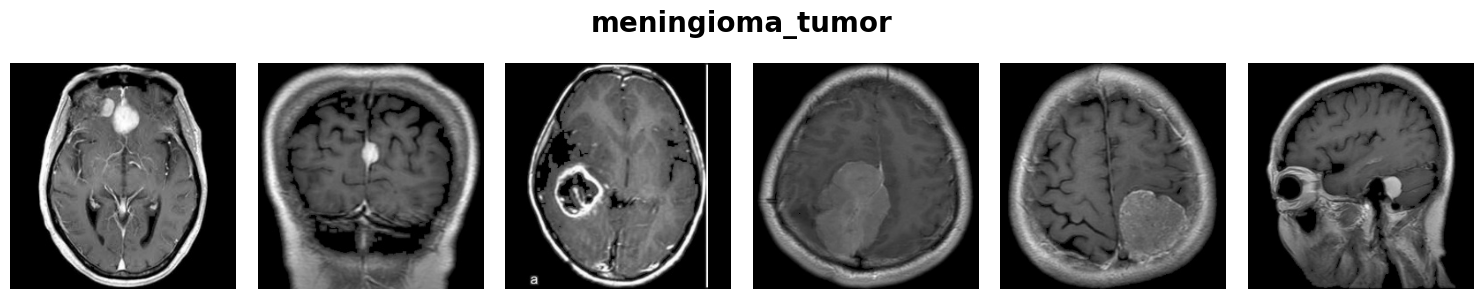

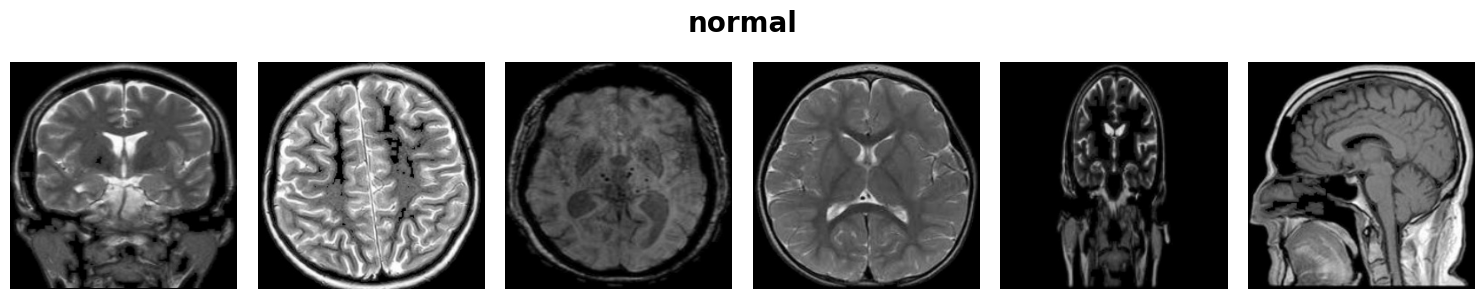

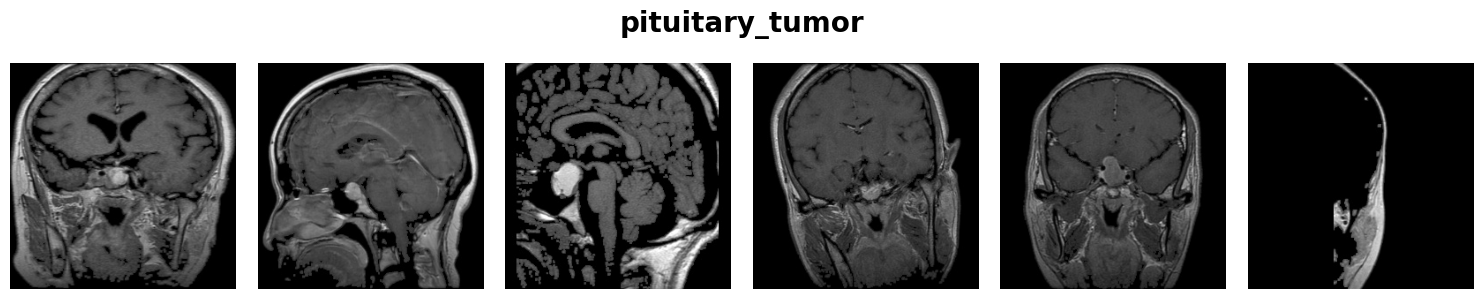

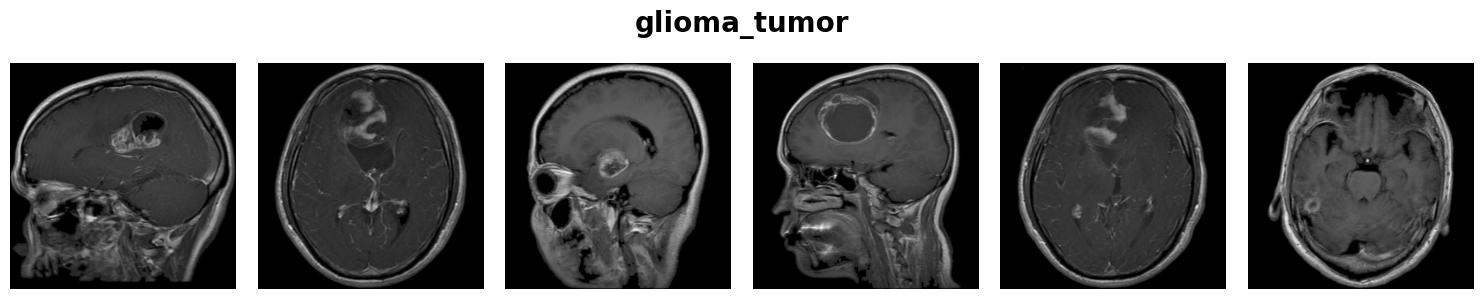

In [ ]:
for class_name in classes :
    # To create a plot with 1 row and 6 column
    fig, ax = plt.subplots(1, 6, figsize=(15, 3))
    # Define a variable for each class_name's path by joining base_directory and each class_name
    class_path = os.path.join(base_dir, class_name)
    # Files is a list of all image names in each folder (class)
    files = os.listdir(class_path)
    # Choose 6 random image from each class to show in plot
    random_images = random.choices(files, k=6)
    # A loop to iterate in each 6 random images
    for i in range(6) :
        # print class_name as suptitle for each class
        plt.suptitle(class_name, fontsize=20, fontweight='bold')
        # variable img is path of image, by joining class_path and image file name
        img = os.path.join(class_path ,random_images[i])
       # load image in img variable using keras.utils.load_img(image_path)
        img = keras.utils.load_img(img)
        # Plot image
        ax[i].imshow(img)
        # Turn axis off
        ax[i].axis('off')
    # Make plots to become nearer to each other
    plt.tight_layout()

In [5]:
# Count is a list to store number of images for each class.
counts = []
# Loop over classes to iterate below code for each class
for class_name in classes :
    # Define class path by joining base_directory and class_name
    class_path = os.path.join(base_dir, class_name)
    # Add number of files in each class to count list
    counts.append(len(os.listdir(class_path)))

# Define plot size
plt.figure(figsize=(13, 4))
# Using seaborn to plot a barplot for each class
ax = sns.barplot(y=classes, x=counts)
# Set X-axis range and ticks
ax.set_xticks(range(0, 950, 100))
# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2.,
            '{}'.format(counts[i]),
            va="center", fontsize=10)
# Set plot title
plt.title('Number of images per class', fontsize=25, fontweight='bold')
# Set Y-axis label
plt.ylabel('Classes', fontsize=15)
# Set X-axis label
plt.xlabel('Number of samples', fontsize=15)
# Show plot
plt.show()

NotADirectoryError: [Errno 20] Not a directory: 'archive/Training/.DS_Store'

In [ ]:
sum_count_before = sum(counts)
print(colored(f'Number of all images is : {sum_count_before}', 'blue', attrs=['bold']))

Number of all images is : 4014


In [ ]:
train_full = keras.utils.image_dataset_from_directory(
    directory=base_dir,        # Path of base directory
    labels='inferred',         # to generate labels from the directory structure
    label_mode='categorical',  # type of labels
    class_names=classes,       # list of class_names
    shuffle=True,              # To shuffle dataset
    seed=42,                   # Optional random seed for shuffling and transformations
    batch_size=32,             # Define batch size
    image_size=(224, 224)      # Size to resize images to after they are read from disk
 )

Found 4014 files belonging to 4 classes.


In [ ]:
train_full = train_full.shuffle(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
num_of_full_train_batches = len(train_full)
print((f'Number of batches in train_full : {num_of_full_train_batches}'))

Number of batches in train_full : 126


In [ ]:
num_train_batches = int(num_of_full_train_batches * 0.80)
# Define variable to store number of batches for validation and test dataset
num_valid_test_batches = num_of_full_train_batches - num_train_batches

print(f'Number of  Train  batches : {num_train_batches}')
print(f'Number of Validation batches : {num_valid_test_batches//2}')
print(f'Number of Test batches : {num_valid_test_batches//2}')

Number of  Train  batches : 100
Number of Validation batches : 13
Number of Test batches : 13


In [ ]:
# Shuffle dataset
train_full = train_full.shuffle(buffer_size=3)

# Apply above settings to main dataset to split to train, validation and test dataset
train_ds = train_full.take(num_train_batches)
remain_ds = train_full.skip(num_train_batches)
valid_ds = remain_ds.take(num_valid_test_batches//2)
test_ds = remain_ds.skip(num_valid_test_batches//2)

In [ ]:
print(f'Number of train batches : {len(train_ds)}')
print(f'Number of valid batches : {len(valid_ds)}')
print(f'Number of test  batches : {len(test_ds)}')

Number of train batches : 100
Number of valid batches : 13
Number of test  batches : 13


In [ ]:
pre_trained_model = keras.applications.ResNet50V2(
    weights='imagenet', classes=4, input_shape=(224, 224, 3), include_top=False
)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
model = keras.models.Sequential()
model.add(pre_trained_model)                           # At first add our pre-trained model
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.GlobalAveragePooling2D())       # Apply GlobalAveragePooling2D
# model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu')) # Add a Dense layer with 1024 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(512, activation='relu'))  # Add a Dense layer with 512 neuron with activation='relu'
model.add(keras.layers.Dropout(0.5))                   # Use a Dropout layer to avoid over-fitting
model.add(keras.layers.Dense(4, activation='softmax')) # Add a Dense layer with number fo classes neuron as output with activation='softmax'

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=5,                                        # Number of epochs to train
    validation_data=valid_ds,                          # Validation dataset
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr] # List of call backs
)

Epoch 1/5


In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/IAI-PROJECT/my_model.h5')

In [ ]:
model.evaluate(test_ds)

13/13 [==============================] - 656s 5s/step - loss: 0.0401 - accuracy: 0.9856


[0.04008069261908531, 0.9855769276618958]

In [ ]:
X_test = []
y_test = []

for X, y in test_ds:
    # `.numpy()` converts the TensorFlow tensors to Numpy arrays
    X_test.append(X.numpy())
    y_test.append(y.numpy())

# Depending on your dataset, X_test and y_test might be lists of Numpy arrays.
# You might need to concatenate them if you prefer single Numpy arrays.
# This is common for image data or when each batch is a separate array.
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


In [ ]:
test_ds

<_SkipDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predictions=model.predict(X_test)

13/13 [==============================] - 70s 5s/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)))

[[ 70   0   1   1]
 [  0  93   1   0]
 [  0   0 146   0]
 [  0   0   1 103]]


In [ ]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       1.00      0.99      0.99        94
           2       0.98      1.00      0.99       146
           3       0.99      0.99      0.99       104

    accuracy                           0.99       416
   macro avg       0.99      0.99      0.99       416
weighted avg       0.99      0.99      0.99       416



In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
from keras.models import load_model

In [ ]:
history = load_model('/content/drive/MyDrive/IAI-PROJECT/MyModel.keras')

In [ ]:
plot_loss_curves(history)

TypeError: 'NoneType' object is not subscriptable